# AlexNet

Running AlexNet on fruits & vegetables dataset.

Model references:

- <https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html>
- <https://arxiv.org/pdf/1404.5997>


In [1]:
import json
import requests
import torch
import matplotlib.pyplot as plt
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import DataLoader
from torchinfo import summary
from torch import nn

from cvision.data import get_fruits, VisionDataset
from cvision.gpu import get_device
from cvision.training import ModelTrainer

In [2]:
weights = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights=weights)

In [3]:
data = get_fruits(remote="", localdir="/mnt/e/torch/fruits", force=False)

Data already exists.


## Test the pretrained model

Check AlexNet output before customizing prediction head.

In [4]:
model.eval()
transform = weights.transforms()

In [5]:
transform # OK

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
# get a batch of random images

ds_test = data["test_dataset"]
ds_test.set_transform(transform)
loader = DataLoader(ds_test, batch_size=32, shuffle=True)

images, labels = next(iter(loader))

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [8]:
logits = model(images)
probs = torch.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

In [9]:
preds

tensor([986, 418, 943, 989, 951, 943, 716, 816, 954, 944, 722, 948, 112, 945,
        945, 519, 945, 957, 950, 582, 584, 987, 943, 911, 989, 117, 943, 936,
        902, 945, 957, 942])

In [10]:
# get imagenet class names from keras, you might need a different url if this breaks

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
res = requests.get(url)
res.raise_for_status()
classes = json.loads(res.content) # formatted as cl_idx dict: {"n": ["id", "name"]}

In [11]:
pred_classes = [classes[str(pred.item())][1] for pred in preds]

In [12]:
pred_classes[:5] # OK

["yellow_lady's_slipper", 'ballpoint', 'cucumber', 'hip', 'lemon']

In [13]:
# renormalize batch

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

batch_re = images * std + mean
batch_re = torch.clamp(batch_re, 0, 1)

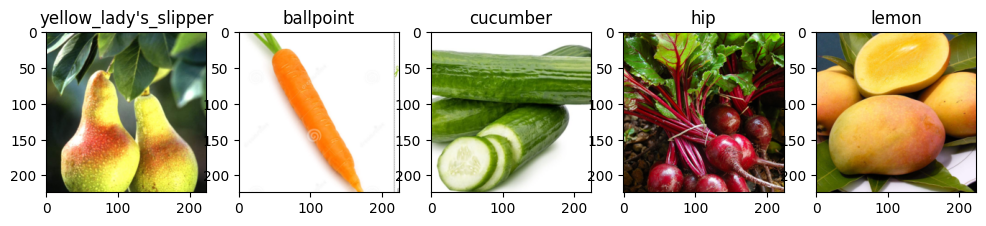

In [14]:
f, ax = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    ax[i].imshow(batch_re[i].permute(1, 2, 0))
    ax[i].set_title(pred_classes[i])

## Customize prediction head

In [15]:
summary(model)

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       23,296
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       307,392
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       663,936
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       884,992
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      590,080
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                   

In [16]:
model.classifier # built-in classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [17]:
ds_train = data["train_dataset"]
ds_val = data["val_dataset"]
ds_test = data["test_dataset"]
ds_train.set_transform(transform)
ds_val.set_transform(transform)
ds_test.set_transform(transform)
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=128, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=128, shuffle=False)

In [18]:
n_classes = len(ds_train.classes)
n_classes

36

In [19]:
n_units = 1024

fv_classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=n_units, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=n_units, out_features=n_units//2, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=n_units//2, out_features=n_classes, bias=True)
)

In [20]:
model_custom = alexnet(weights=weights)
for param in model_custom.parameters():
    param.requires_grad = False
model_custom.classifier = fv_classifier

summary(model_custom, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 36]                  --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          (23,296)
│    └─ReLU: 2-2                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         (307,392)
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         (663,936)
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         (884,992)
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]

In [21]:
# TODO: move to package
def accfn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    n_correct = torch .eq(y_true, y_pred).sum().item()
    return n_correct / y_true.shape[0]

In [22]:
import importlib
import cvision.training
importlib.reload(cvision.training)

trainer = ModelTrainer(
    model=model_custom,
    train_loader=dl_train,
    eval_loader=dl_val,
    loss_fn=nn.CrossEntropyLoss(),
    accuracy_fn=accfn,
    optimizer=torch.optim.Adam(params=model_custom.parameters(), lr=0.003),
    device=get_device(),
    mlflow_uri="http://127.0.0.1:5000",
    mlflow_exp_name="alexnet-t1"
)

In [23]:
import importlib
import cvision.training
importlib.reload(cvision.training)

trainer.train(n_epochs=20)

Epoch #1 | Train loss 3.6404 | Train acc 0.2707
Epoch #1 | Val loss 0.9802 | Val acc 0.7410
Epoch #2 | Train loss 1.4921 | Train acc 0.5548
Epoch #2 | Val loss 0.4261 | Val acc 0.8581
Epoch #3 | Train loss 1.1796 | Train acc 0.6521
Epoch #3 | Val loss 0.4711 | Val acc 0.8410
Epoch #4 | Train loss 1.0489 | Train acc 0.6768
Epoch #4 | Val loss 0.3242 | Val acc 0.9143
Epoch #5 | Train loss 0.8867 | Train acc 0.7232
Epoch #5 | Val loss 0.2431 | Val acc 0.9121
Epoch #6 | Train loss 0.8401 | Train acc 0.7452
Epoch #6 | Val loss 0.2037 | Val acc 0.9559
Epoch #7 | Train loss 0.8030 | Train acc 0.7566
Epoch #7 | Val loss 0.2029 | Val acc 0.9318
Epoch #8 | Train loss 0.7936 | Train acc 0.7655
Epoch #8 | Val loss 0.2075 | Val acc 0.9438
Epoch #9 | Train loss 0.7447 | Train acc 0.7846
Epoch #9 | Val loss 0.2045 | Val acc 0.9405
Epoch #10 | Train loss 0.7151 | Train acc 0.7913
Epoch #10 | Val loss 0.1778 | Val acc 0.9483
Epoch #11 | Train loss 0.7286 | Train acc 0.7925
Epoch #11 | Val loss 0.1879 |

In [24]:
torch.save(model_custom.state_dict(), "/mnt/e/torch/models/alex-01.pt")

## Test run

In [33]:
def predict(model: nn.Module, X: torch.Tensor, device) -> torch.Tensor:
    model.eval()
    model.to(device)
    with torch.inference_mode():
        X = X.to(device)
        forward = model(X)
        probs = torch.softmax(forward, dim=1)
        y_hat = torch.argmax(probs, dim=1)
        return y_hat

In [36]:
t_images, t_labels = next(iter(dl_test))

preds = predict(model_custom, t_images, "cuda")
pred_classes = [ds_test.classes[p] for p in preds]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1632845].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.622571].


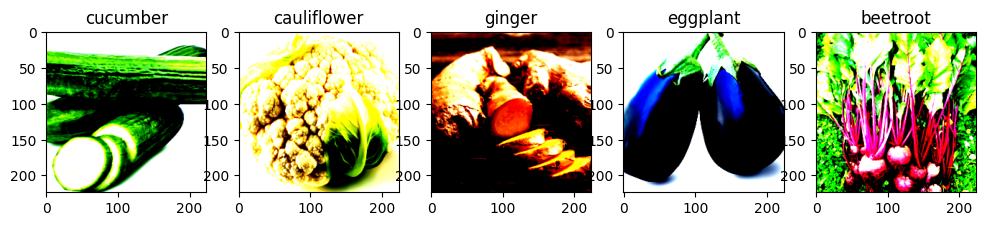

In [49]:
f, ax = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    r_idx = torch.randint(0, len(t_images), (1,))
    ax[i].imshow(t_images[r_idx].squeeze().permute(1, 2, 0))
    ax[i].set_title(pred_classes[r_idx])